# Bayesian Optimization

## O que é?

A otimização de bayes consiste em gerar uma função "substituta" para a função objetivo (seria a função ideal para descrever o modelo), utiliza os pontos mais próximos entre a função real e a substituta e gera uma nova zona ao redor desses pontos. Tenta otimizar os hiperparâmetros da função substituta de modo que aproxime cada ponto da zona de variação com o valor real da função. Ao invés de testar todo o conjunto de hiperparâmetros (grid search) ou pontos aleatórios em uma lista predefinida (random search) a otimização de Bayes testa os conjuntos de hp baseada nos resultados anteriores.

Por exemplo: 

Considere um algoritmo Random Forest e o hiperparâmetro n_estimators (nº de árvores), os métodos grid e random search percorreriam uma lista de possíveis conjuntos de hiperparâmetros independente do resultado de um ou outro conjunto, enquanto isso, a otimização bayesiana encontra uma região no espaço de configurações hiperparamétricas onde estão os melhores resultados, e aplica suas buscas apenas nessa região.

https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

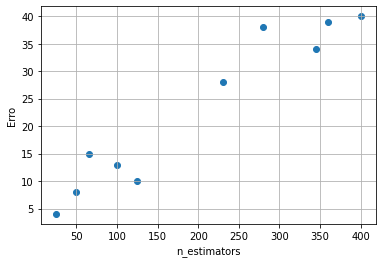

Nesse exemplo um número de estimadores bom seria inferior a 150, sendo assim a otimização bayesiana utiliza o conjunto de hiperparâmetros dos modelos localizados nessa região e busca novos conjuntos próximos aos encontrados


In [9]:
import numpy as np
import matplotlib.pyplot as plt

Xplot = np.array([25, 50, 65, 100, 125, 230, 280, 345, 360, 400])
Yplot = np.array([4, 8, 15, 13, 10, 28, 38, 34, 39, 40])

plt.figure()
plt.scatter(Xplot, Yplot)
plt.grid()
plt.ylabel("Erro")
plt.xlabel("n_estimators")
plt.show()

print("Nesse exemplo um número de estimadores bom seria inferior a 150, sendo assim a otimização bayesiana utiliza o conjunto de"
      " hiperparâmetros dos modelos localizados nessa região e busca novos conjuntos próximos aos encontrados")

### Exemplo

Para implementar a otimização bayesiana será utilizada a biblioteca hyperopt

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll import scope

#### Coletando os dados

In [16]:
#Recolhendo dados do facebook e preparando dataset

import pandas_datareader.data as web
import datetime as dt

end = dt.datetime(2020, 6, 1)
start = dt.datetime(2019, 1, 1)

df = web.DataReader("FB", 'yahoo', start, end)

df = df.reset_index()
df = df.drop(columns=['Open','Date','High','Low','Volume','Adj Close'])
df = df.rename(columns={'Close': 'Close 0'})

def window (df, w):
    for i in range(1,w):
        df['Close '+str(i)] = df['Close '+str(i-1)].shift(1)
    return df
        
df = window(df,5)
df = df.rename(columns={'Close 0': 'Target'})
df.dropna(inplace=True)
df.head()

,Target,Close 1,Close 2,Close 3,Close 4
4,142.529999,138.050003,137.949997,131.740005,135.679993
5,144.229996,142.529999,138.050003,137.949997,131.740005
6,144.199997,144.229996,142.529999,138.050003,137.949997
7,143.800003,144.199997,144.229996,142.529999,138.050003
8,145.389999,143.800003,144.199997,144.229996,142.529999


In [17]:
#Separando dados de treino e teste
X = df.loc[:, ['Close 1','Close 2','Close 3','Close 4']]
y = df.loc[:, 'Target'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#### Criando modelos padrão

In [42]:
# configuração default para svr
# kernel = rbf, degree = 3, gamma = scale, coef0 = 0.0, tol = 1e-3, C=1.0,
# epsilon = 0.1, shrinking = True, cache_size = 200, verbose = False, max_iter = -1
svm_default = SVR()

# Random Forest
# n_estimators = 100, criterion = "mse", max_depth = None, min_samples_split = 2, max_features = "auto", 
# oob_score=false, max_samples=none
rf_default = RandomForestRegressor()

# XGBoost
# n_estimators, max_depth, learning_rate, booster, gamma, subsample, reg_alpha, reg_lambda
xgb_default = xgb.XGBRegressor()

#### Criando lista de hp

In [65]:
svm_space= {
    'kernel': hp.choice('kernel', ['linear','rbf']),
    'gamma': hp.choice('gamma', ['scale','auto']),
    'C': hp.quniform('C', 0.1, 1.0, 0.1),
    'epsilon': hp.quniform('epsilon', 0.1, 1.0, 0.1),
}

rf_space= {
    'criterion': hp.choice('criterion', ['mse','mae']),
    'max_features': hp.choice('max_features', ['sqrt','log2','auto']),
    'n_estimators': scope.int(hp.quniform('n_estimators', 25, 600, 25)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
}

xgb_space= {
    'n_estimators': scope.int(hp.quniform('n_estimators', 25, 600, 25)),
    'learning_rate': hp.quniform('learning_rate', 0.1, 1.0, 0.1),
    'booster': hp.choice('booster', ['gbtree','gblinear']),
}

#### Definindo função objetivo, aquela que deve ser otimizada

In [66]:
def funcao_objetivo_svm(params):
    model = SVR(**params)
    score = cross_val_score(model, X_train, y_train, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK} 

def funcao_objetivo_rf(params):
    model = RandomForestRegressor(**params)
    score = cross_val_score(model, X_train, y_train, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK} 

def funcao_objetivo_xgb(params):
    model = xgb.XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, cv=5).mean()
    return {'loss': -score, 'status': STATUS_OK} 

In [67]:
num_eval = 100

trials = Trials()

svm_best_param = fmin(funcao_objetivo_svm,#Função a ser otimizada
                  svm_space,              #Espaço de hp
                  algo=tpe.suggest,       #Algoritmo responsável por construir a probabilidade da busca em cada região
                  max_evals=num_eval,     #Número de tentativas
                  trials=trials,          #Armazena o andamento do processo
                  rstate= np.random.RandomState(1))

trials = Trials()

rf_best_param = fmin(funcao_objetivo_rf,  #Função a ser otimizada
                  rf_space,               #Espaço de hp
                  algo=tpe.suggest,       #Algoritmo responsável por construir a probabilidade da busca em cada região
                  max_evals=num_eval,     #Número de tentativas
                  trials=trials,          #Armazena o andamento do processo
                  rstate= np.random.RandomState(1))

trials = Trials()

xgb_best_param = fmin(funcao_objetivo_xgb,#Função a ser otimizada
                  xgb_space,              #Espaço de hp
                  algo=tpe.suggest,       #Algoritmo responsável por construir a probabilidade da busca em cada região
                  max_evals=num_eval,     #Número de tentativas
                  trials=trials,          #Armazena o andamento do processo
                  rstate= np.random.RandomState(1))

100%|█████████████████████████████████████████████| 100/100 [00:49<00:00,  2.03trial/s, best loss: -0.9546315277552141]


In [68]:
print("SVM:",svm_best_param)
print("RF:",rf_best_param)
print("XGB:",xgb_best_param)

SVM: {'C': 0.1, 'epsilon': 0.8, 'gamma': 0, 'kernel': 0}
RF: {'criterion': 1, 'max_features': 2, 'min_samples_split': 10.0, 'n_estimators': 550.0}
XGB: {'booster': 1, 'learning_rate': 0.9, 'n_estimators': 350.0}


In [69]:
svm_tuned = SVR(C=0.1, epsilon = 0.8, gamma = 'scale', kernel = 'linear')

rf_tuned = RandomForestRegressor(n_estimators = 550, min_samples_split = 10, max_features = 2, criterion = 'mae')

xgb_tuned = xgb.XGBRegressor(n_estimators = 350,learning_rate = 0.9, booster = 'gblinear')

In [70]:
#Modelos padrão
svm_default.fit(X_train,y_train)
rf_default.fit(X_train,y_train)
xgb_default.fit(X_train,y_train)

#Modelos ajustados
svm_tuned.fit(X_train,y_train)
rf_tuned.fit(X_train,y_train)
xgb_tuned.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=-1, importance_type='gain', interaction_constraints=None,
             learning_rate=0.9, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=350, n_jobs=0, num_parallel_tree=None, random_state=0,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=None,
             tree_method=None, validate_parameters=1, verbosity=None)

In [71]:
#Recolhendo pontuações

#Modelos padrão
svm_default_score = svm_default.score(X_test,y_test)
rf_default_score = rf_default.score(X_test,y_test)
xgb_default_score = xgb_default.score(X_test,y_test)

#Modelos ajustados
svm_tuned_score = svm_tuned.score(X_test,y_test)
rf_tuned_score = rf_tuned.score(X_test,y_test)
xgb_tuned_score = xgb_tuned.score(X_test,y_test)

In [72]:
#Recolhendo previsões

#Modelos padrão
svm_default_pred = svm_default.predict(X)
rf_default_pred = rf_default.predict(X)
xgb_default_pred = xgb_default.predict(X)

#Modelos ajustados
svm_tuned_pred = svm_tuned.predict(X)
rf_tuned_pred = rf_tuned.predict(X)
xgb_tuned_pred = xgb_tuned.predict(X)

In [73]:
print('--RELATÓRIO--')

print('SVM:')
print('Default score: ',svm_default_score)
print('Tuned score: ',svm_tuned_score)
print('--------------------')

print('Random Forest:')
print('Default score: ',rf_default_score)
print('Tuned score: ',rf_tuned_score)
print('--------------------')

print('XGBoost:')
print('Default score: ',xgb_default_score)
print('Tuned score: ',xgb_tuned_score)
print('--------------------')

--RELATÓRIO--
SVM:
Default score:  0.85605189803503
Tuned score:  0.9501425949103359
--------------------
Random Forest:
Default score:  0.9372257586069425
Tuned score:  0.941848351258256
--------------------
XGBoost:
Default score:  0.9347909493592949
Tuned score:  0.9229600786216103
--------------------


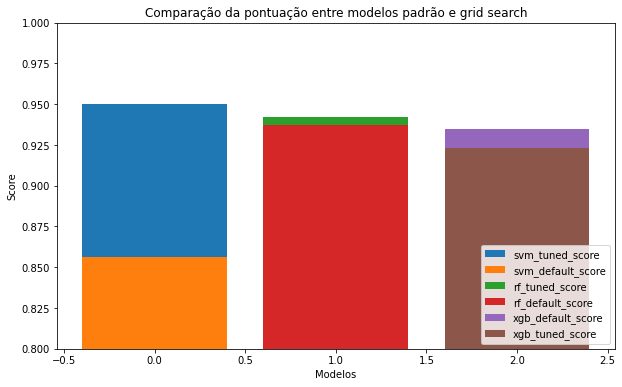

In [74]:
#Visualizando resultados

plt.figure(figsize=(10,6))

plt.bar(0, svm_tuned_score, label='svm_tuned_score')
plt.bar(0, svm_default_score, label='svm_default_score')

plt.bar(1, rf_tuned_score, label='rf_tuned_score')
plt.bar(1, rf_default_score, label='rf_default_score')

plt.bar(2, xgb_default_score, label='xgb_default_score')
plt.bar(2, xgb_tuned_score, label='xgb_tuned_score')

plt.ylim(0.8, 1.0)
plt.ylabel('Score')
plt.xlabel('Modelos')
plt.title('Comparação da pontuação entre modelos padrão e grid search')
plt.legend(loc='lower right')
plt.show()